# **Introducción a la visión artificial con Python y OpenCV**


<div style="display: flex;gap: 400px; align-items: center;">
  <img src="https://upload.wikimedia.org/wikipedia/commons/c/c3/Python-logo-notext.svg" alt="Logo de Python" width="150" style="margin-right: 400px;">
  <img src="https://www.cidaut.es/wp-content/uploads/2023/12/logotipo-simple-color.png" alt="Logo de Cidaut" width="220">
</div>


En este taller vamos a aprender a ejecutar algunas tareas muy simples de visión artificial. Para simplifircalo más el tutorial será realizado con Python. La idea es daros a conocer nuevas herramientas que se utilizan en este campo y que ya están desarrolladas. Las principales librerías que vamos a utilizar para esto son:
- `OpenCV`. La librería más conocida de visión artificial en Python y C++. Es muy útil para construir nuevos proyectos o librerías en base a sus métodos. Utiliza la formulación tensorial de `Numpy`.

- `Ultralytics`. Una libreria moderna basada en `PyTorch` y `OpenCV`. Mantiene y mejora el algoritmo rápido de detección YOLO.

## **Índice**

Con este taller se pretende que obtengais recursos básicos para:

- Leer una imagen con OpenCV y aplicar filtros de procesamiento tradicionales.
- Repetir esto con videos.
- Utilizar YOLO para detectar, segmentar y estudiar objetos de la imagen.

### 0. Descarga de scripts

In [8]:
!wget https://raw.githubusercontent.com/cidautai/Taller-CV/main/png2ascii.py
!wget https://raw.githubusercontent.com/cidautai/Taller-CV/main/quantized.py

--2025-10-28 10:42:41--  https://raw.githubusercontent.com/cidautai/Taller-CV/main/png2ascii.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4215 (4.1K) [text/plain]
Saving to: ‘png2ascii.py.1’

png2ascii.py.1      100%[===================>]   4.12K  --.-KB/s    in 0s      

2025-10-28 10:42:42 (61.6 MB/s) - ‘png2ascii.py.1’ saved [4215/4215]

--2025-10-28 10:42:42--  https://raw.githubusercontent.com/cidautai/Taller-CV/main/quantized.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3447 (3.4K) [text/plain]
Saving to: ‘quanti

## 1. Procesamiento de imagen con OpenCV.

 <img src="https://opencv.org/wp-content/uploads/2020/07/OpenCV_logo_black-2.png" alt="Logo de OpenCV" width="150" style="margin-right: 400px;">

In [2]:
# Instalamos las librerías necesarias para este apartado
!pip install opencv-python matplotlib

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests

Definimos ahora una función con la que poder descargar imágenes de la web. Para ello utilizamos la librería `requests`.

Representaremos las imágenes con la librería `matplotlib`.

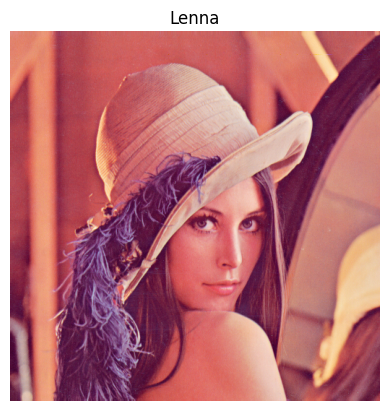

In [4]:
# URL de la imagen
def get_img_from_url(url = "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png"):

  response = requests.get(url, headers = {'User-Agent': 'Mozilla/5.0'})
  image_array = np.frombuffer(response.content, np.uint8)
  image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

  # Pasar de BGR a RGB, ya que OpenCV usa BGR por defecto
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image_rgb
image_rgb = get_img_from_url()
# Visualizamos la imagen
plt.imshow(image_rgb)
plt.title("Lenna")
plt.axis("off")
plt.show()

Con la función de OpenCV [cvtColor()](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html) podremos hacer las transformaciones de color más típicas en una imagen. Probemos a convertir esta imagen a escala de grises. Es en este espacio en el que calcularemos los bordes de la imagen.

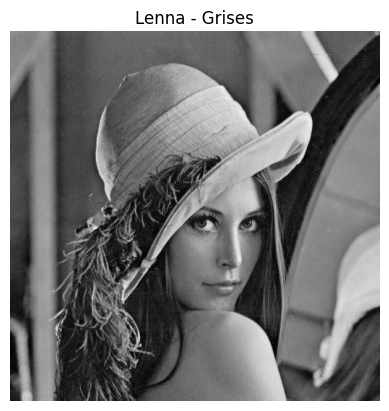

In [5]:
gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap= "gray")
plt.title("Lenna - Grises")
plt.axis("off")
plt.show()

Ya en este dominio, podemos detectar los bordes. Para este caso vamos a utilizar una de las primeras soluciones a este problema: los filtros de Sobel. Estos se pueden interpretar como una aproximación discreta a las derivadas direccionales. Típicamente existen dos tipos, el filtro en X y el filtro en Y, calculando cada uno la derivada parcial discreta a lo largo de esa dirección:

 <img src="https://homepages.inf.ed.ac.uk/rbf/HIPR2/figs/sobmasks.gif" alt="Filtros de Sobel" width="250" style="margin-right: 400px;">

Los filtros se aplican a través de una convolución. La derivada a lo largo del eje x la podemos aproximar por Dx = Gx * Imagen, y lo mismo en el caso de y. * es la operación de convolución que se ilustra muy fácil con el siguiente GIF:

 <img src="https://upload.wikimedia.org/wikipedia/commons/0/04/Convolution_arithmetic_-_Padding_strides.gif" alt="Convolución" width="250" style="margin-right: 400px;">

> Dado que openCV trabaja con tensores de `numpy` podemos utilizar las funciones definidas en esta librería para realizar transformaciones de imagen.

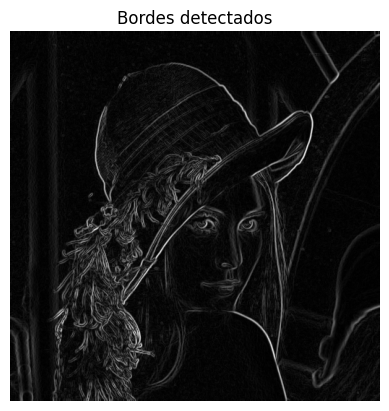

In [6]:
# Calculamos las derivadas en X e Y con los filtros de Sobel
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

# Calculamos la magnitud de el cambio por pixel usando la norma euclídea
sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
# Expresamos este valor en el rango [0, 255] para poder representarlo
sobel_magnitude = np.uint8(255 * sobel_magnitude / np.max(sobel_magnitude))

plt.imshow(sobel_magnitude, cmap='gray')
plt.title("Bordes detectados")
plt.axis("off")
plt.show()

Esta es la solución más simple que existe a la obtención de los bordes. Si quereis probar otras opciones más potentes, podéis consultar el algoritmo `Canny` en el correspondiente blog de la página de [OpenCV](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html).

Con esto ya vemos que existen herramientas para analizar imágenes. A continuación presentamos otras dos funciones que se pueden crear con imagen. Con esto queremos que tengáis una idea de como crear vuestros propios procesamientos de imagen.

In [7]:
import importlib, sys, os
sys.path.append(os.getcwd())

from quantized import quick_quantize_video, quantize_image
from png2ascii import image_to_ascii_art

SyntaxError: invalid character '·' (U+00B7) (quantized.py, line 120)

Siguiendo con la imagen que teníamos antes, o con otra nueva que os interese.

In [ ]:
image_rgb = get_img_from_url()

# Visualizamos la imagen
plt.imshow(image_rgb)
plt.title("Lenna")
plt.axis("off")
plt.show()

### Quantización del color
Primero comencemos cambiando los valores de intensidad que puede tomar la imagen. Hasta ahora leiamos las imágenes con valores para cada pixel en el rango [0,255]. Digamos que en lugar de tener 256 valores distintos, podemos tener solo 5 valores distintos.

Ahora nos vamos a encontrar con muchos menos detalles, ya que hemos hecho una quantización bastante agresiva. Esta reducción del rango de valores se utiliza comunmente en la grabación de vídeos o streaming, ya que permite **reducir** notablemente el peso en memoria del vídeo. Este y otros tipos de algoritmos se conocen como algoritmos de compresión de la imagen. Uno de los métodos más conocidos de compresión es el JPEG:

 <img src="https://comprimeme.wordpress.com/wp-content/uploads/2014/12/lenna-600x197.png" alt="Filtros de Sobel" width="600" style="margin-right: 400px;">

Podeis probar con varios valores de `k` o utilizar el método `kmeans` en vez de `uniform`.

In [ ]:
quant_image = quantize_image(image_rgb, k=5, method= 'uniform')

# Visualizamos la imagen
plt.imshow(quant_image)
plt.title("Lenna")
plt.axis("off")
plt.show()

### Transformación a ASCII

Ya que hemos visto que los valores de intensidad de la imagen se pueden mapear por otros valores, vamos a sustituirlos por algo completamente diferente: caracteres ASCII. El funcionamiento es muy semejante al de la quantización de color que hemos hecho antes. Asociamos a cada uno de los carácteres ASCII un rango de valores de intensidad y sustituimos en la imagen.

In [ ]:
ascii_image= image_to_ascii_art(image_rgb, output_path = 'ascii_lena.png')

print(ascii_image)
# Visualizamos la imagen
plt.imshow(ascii_image)
plt.title("Lenna")
plt.axis("off")
plt.show()

## 2. Procesar video

Una vez visto como se procesan imágenes, podemos plantearnos el procesado de vídeos. En este caso la forma que tendremos de hacerlo con OpenCV es ir recorriendo el video frame a frame, y procesar cada uno de ellos de forma independiente.

Escoged el video que querais para esta tarea. Lo más rápido puede ser cogerlo de Youtube. Coged un video corto, tipo *short* para que los tiempos de procesamiento sean menores. Para descargar el vídeo utilizamos la librería `yt-dlp`.


In [ ]:
# instalamos yt-dlp
!pip install yt-dlp

In [ ]:

import yt_dlp

video_url = "https://www.youtube.com/shorts/n96w_-EXieY"
output_path = "short_video.mp4"

# Configurar opciones para descargar el mejor mp4 posible
ydl_opts = {
    'outtmpl': output_path,   # nombre del archivo de salida
    'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]',  # preferir mp4
    'quiet': True
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([video_url])

print("Video descargado:", output_path)


Una vez descargado ya podemos empezar a trabajar en él. Para ello nos valemos de la clase `VideoCapture()` para crear el objeto video. De esta podemos extraer multitud de parámetros del vídeo. Como queremos guardar el video una vez procesado recogemos los fps y tamaño del video original. El objeto sobre el que guardamos el vídeo es de la clase `VideoWriter()`. En ambos objetos, al finalizalir el procesamiento deberemos aplicar su método *release()*.

> La clase `VideoCapture()` es realmente útil para aplicaciones en tiempo real, ya que permite recibir distintas entradas de vídeo, como cámaras conectadas al equipo, o *streaming*.

Vamos a obtener los bordes de la imagen usando los filtros de Sobel:

In [ ]:
input_path = "short_video.mp4"
output_path = "video_sobel.avi"

# Abrir el video original
cap = cv2.VideoCapture(input_path)

# Obtener dimensiones y FPS del video de entrada
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Crear VideoWriter para el resultado (video en escala de grises)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height), False)

frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convertir a escala de grises
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Aplicar Sobel en X e Y
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    # Calcular magnitud del gradiente y normalizar
    sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
    sobel_magnitude = np.uint8(255 * sobel_magnitude / np.max(sobel_magnitude))

    # Escribir el frame procesado directamente en el nuevo video
    out.write(sobel_magnitude)

    frame_idx += 1
    if frame_idx % 50 == 0:
        print(f"Procesados {frame_idx} frames...")

# Liberar recursos
cap.release()
out.release()
print(f"Video procesado guardado en: {output_path}")

Y al igual que hicimos con la imagen, también podríamos quantizar el color del vídeo.

In [ ]:
quant_video = quick_quantize_video('short_video.mp4', output_path='video_quant.mp4', colors = 5)

Estas son algunas de las muchas cosas que se pueden plantear con la librería OpenCV. Si queréis formaros más en este tema, disponéis de unos [tutoriales](https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html) muy buenos en su página principal.

## **3. Procesamiento con YOLO**


 <img src="https://cdn.prod.website-files.com/680a070c3b99253410dd3dcf/68e4eb1e9893320b26cc02c3_Ultralytics%20Logo.png.svg" alt="Logo de OpenCV" width="300" style="margin-right: 400px;">

En esta sección vamos a explorar una aplicación más avanzada de la visión artificial:
la detección y/o reconocimiento de objetos mediante redes neuronales convolucionales.

Para ello utilizaremos la librería `ultralytics`, que incluye los modelos YOLO
(*You Only Look Once*). Estos modelos destacan por su rapidez y precisión,
siendo ampliamente usados en detección de personas, vehículos o animales en tiempo real.



Instalamos la librería con el siguiente comando:

In [ ]:
# instalamos ultralytics
!pip install ultralytics

In [ ]:
import ultralytics

Cargamos ahora un modelo preentrenado de YOLO.
Si no se indica un modelo específico, por defecto se utiliza `yolov8s.pt`. Pero es una versión un tanto desactualizada.

Por ello, en este caso usaremos `yolo11s.pt`, una versión optimizada y ligera, adecuada para demostraciones y ejecución rápida en CPU.

Ejecutamos la detección con el modelo cargado. El método `model()` realiza todo el proceso:
- Inferencia sobre la imagen.
- Detección de objetos y sus coordenadas.
- Asignación de etiquetas y confianza.

In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import requests
import numpy as np

# Cargar un modelo pre-entrenado (por ejemplo, YOLOv8s)
# Se usará yolov8s.pt por defecto si no se especifica otro
model = YOLO('yolo11s.pt')

# URL de la imagen para detección
image_url = "https://ultralytics.com/images/bus.jpg"

# Descargamos la imagen desde la URL dada
image_rgb = get_img_from_url(url=image_url)


# Ejecutar la detección en la imagen
results = model(image_rgb)

# Guardar la imagen con las detecciones en el directorio por defecto ('runs/detect/...')
for r in results:
    im_array = r.plot()  # Ploteo de imagen RGB en formato numpy de las predicciones del modelo ejecutado
    im = cv2.cvtColor(im_array, cv2.COLOR_RGB2BGR) # Convertimos RGB a BGR
    output_path = 'output_yolo.png'  # Elegimos un nombre para guardar la imagen
    cv2.imwrite(output_path, im) # Finalmente guardamos la imagen BGR con OpenCV,


print(f"Imagen con detecciones guardada en: {output_path}")

img_to_plot = np.concatenate((image_rgb, im_array), axis=1)
# Opcional: mostrar la imagen con detecciones (puede ser grande)
plt.imshow(img_to_plot)
# plt.title("YOLO Detecciones")
plt.axis("off")
plt.show()

Podemos aplicar exactamente el mismo proceso a un vídeo. La librería `ultralytics`
permite procesar directamente vídeos o flujos de cámara mediante el método `predict()`.

El parámetro `save=True` guarda automáticamente el vídeo anotado en el directorio `runs/detect/`.

In [ ]:
from ultralytics import YOLO
import cv2

# Cargar un modelo pre-entrenado (por ejemplo, YOLOv8s)
model = YOLO('yolo11s.pt')

# Ruta del video descargado
video_path = 'short_video.mp4'

# Ejecutar la detección en el video
# El método predict de YOLO puede procesar videos directamente
results = model.predict(video_path, stream=True, save=True, verbose=False) # save=True guarda el video con las detecciones

print("Procesamiento del video con YOLO completado. El video con las detecciones se ha guardado en el directorio 'runs/detect'.")

Ya para terminar, vamos a darle un uso a lo que hemos visto en el ejemplo anterior. Aprovechando la detección de personas, vamos a darle una aplicación muy sencilla y a la vez muy util.

En concreto, vamos a usar YOLO para contar personas dentro de una región de un vídeo dentro de una cola de embarque en un aeropuerto.
Este tipo de solución se usa en control de aforos o sistemas automáticos en aeropuertos y estaciones.

Para ello utilizaremos el módulo `ObjectCounter` incluido en `ultralytics.solutions`.

In [ ]:
from ultralytics.utils.downloads import safe_download
from ultralytics import solutions

# Descarga de un video de ejemplo
safe_download("https://github.com/ultralytics/notebooks/releases/download/v0.0.0/queue-management-demo.mp4")


def count_objects_in_region(video, output_video_path, model_path, classes= [0]):
    """Cuenta objetos dentro de una región específica del vídeo."""
    cap = cv2.VideoCapture(video)
    assert cap.isOpened(), "Error leyendo el archivo de video"
    w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))
    video_writer = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))

    # Región de interés definida por cuatro puntos
    region_points = [(250, 570), (1200, 350), (1200, 390), (250, 610)]

    # Inicializamos el contador de objetos
    counter = solutions.ObjectCounter(show=True, show_out=False, verbose=False, region=region_points, model=model_path, classes = classes)

    while cap.isOpened():
        success, im0 = cap.read()
        if not success:
            print("Video finalizado o frame vacío.")
            break
        results = counter(im0)
        video_writer.write(results.plot_im)

    cap.release()
    video_writer.release()
    cv2.destroyAllWindows()

# Ejecutamos la función de conteo sobre el video de ejemplo
count_objects_in_region("queue-management-demo.mp4", "output_video_queue.avi", "yolo11n.pt")